
# Face Modification using VAE, β-VAE, VQ-VAE and GAN

---

## Objective

To study how different latent representations influence:
- Reconstruction quality
- Attribute manipulation
- Sample realism

Models implemented:
1. VAE
2. β-VAE (β = 2, 4, 10)
3. VQ-VAE + PixelCNN
4. GAN (DCGAN)

All models are trained for **10 epochs** on the CelebA dataset.


## 1. Imports & Global Configuration

Mount Drive location where already downloaded Dataset is available.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

IMG_SIZE = 128
BATCH_SIZE = 64
LATENT_DIM = 128
EPOCHS = 10

print("TensorFlow Version:", tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 130.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 161.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 217.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 29.8 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


TensorFlow Version: 2.20.0


## 2. CelebA Dataset Loading (Local/Drive Directory)

In [ ]:
import glob

CELEBA_IMG_DIR = "/content/drive/MyDrive/Dataset/img_align_celeba"  # <-- UPDATE THIS PATH

# Use glob to find all .jpg files recursively (handles subfolders)
file_pattern = os.path.join(CELEBA_IMG_DIR, "**", "*.jpg")
image_list = glob.glob(file_pattern, recursive=True)

image_paths = tf.constant(image_list, dtype=tf.string)

def preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return tf.cast(img, tf.float32) / 255.0

celeba_ds = (
    tf.data.Dataset.from_tensor_slices(image_paths)
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(50000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("Total images:", len(image_list))

Total images: 116856


## 3. Variational Autoencoder (VAE)

In [ ]:

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

def build_encoder():
    x = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    h = layers.Conv2D(32, 4, strides=2, padding="same", activation="relu")(x)
    h = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(h)
    h = layers.Conv2D(128, 4, strides=2, padding="same", activation="relu")(h)
    h = layers.Flatten()(h)

    z_mean = layers.Dense(LATENT_DIM, name="z_mean")(h)
    z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(h)

    return keras.Model(x, [z_mean, z_log_var], name="Encoder")


def build_decoder():
    z = layers.Input((LATENT_DIM,))

    h = layers.Dense(16 * 16 * 128, activation="relu")(z)
    h = layers.Reshape((16, 16, 128))(h)
    h = layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(h)
    h = layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(h)
    h = layers.Conv2DTranspose(32, 4, strides=2, padding="same", activation="relu")(h)

    out = layers.Conv2DTranspose(
        3, 3, strides=1, padding="same", activation="sigmoid"
    )(h)

    return keras.Model(z, out, name="Decoder")


class VAE(keras.Model):
    def __init__(self, beta=1.0):
        super().__init__()
        self.encoder = build_encoder()
        self.decoder = build_decoder()
        self.sampler = Sampling()
        self.beta = beta

    def train_step(self, x):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x)
            z = self.sampler([z_mean, z_log_var])
            x_hat = self.decoder(z)
            recon = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_hat))
            kl = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            loss = recon + self.beta * kl
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss, "recon": recon, "kl": kl}


Train Variational Autoencoder

In [ ]:

vae = VAE(beta=1.0)
vae.compile(optimizer=keras.optimizers.Adam(1e-4))
vae.fit(celeba_ds, epochs=EPOCHS)


Epoch 1/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1757s 575ms/step - kl: 0.0181 - loss: 0.6333 - recon: 0.6152
Epoch 2/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 283s 134ms/step - kl: 0.0221 - loss: 0.6120 - recon: 0.5899
Epoch 3/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 282s 134ms/step - kl: 0.0247 - loss: 0.6085 - recon: 0.5838
Epoch 4/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 282s 134ms/step - kl: 0.0259 - loss: 0.6069 - recon: 0.5810
Epoch 5/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 281s 134ms/step - kl: 0.0260 - loss: 0.6065 - recon: 0.5805
Epoch 6/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 280s 134ms/step - kl: 0.0261 - loss: 0.6062 - recon: 0.5801
Epoch 7/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 281s 134ms/step - kl: 0.0262 - loss: 0.6060 - recon: 0.5798
Epoch 8/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 282s 134ms/step - kl: 0.0263 - loss: 0.6057 - recon: 0.5794
Epoch 9/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 281s 134ms/step - kl: 0.0263 - loss: 0.6056 - recon: 0.5793
Epoch 10/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 282s 134ms/step - kl: 0.0264 - loss: 0

## 4. Training β-VAE (β = 2, 4, 10)

In [ ]:

betas = [2, 4, 10]
for b in betas:
    print(f"Training β-VAE with beta={b}")
    model = VAE(beta=b)
    model.compile(optimizer=keras.optimizers.Adam(1e-4))
    model.fit(celeba_ds, epochs=EPOCHS)


Training β-VAE with beta=2
Epoch 1/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 282s 133ms/step - kl: 0.0076 - loss: 0.6477 - recon: 0.6326
Epoch 2/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 282s 133ms/step - kl: 0.0100 - loss: 0.6375 - recon: 0.6175
Epoch 3/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 280s 133ms/step - kl: 0.0109 - loss: 0.6270 - recon: 0.6052
Epoch 4/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 280s 133ms/step - kl: 0.0110 - loss: 0.6259 - recon: 0.6038
Epoch 5/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 281s 133ms/step - kl: 0.0115 - loss: 0.6253 - recon: 0.6023
Epoch 6/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 279s 133ms/step - kl: 0.0117 - loss: 0.6250 - recon: 0.6017
Epoch 7/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 282s 133ms/step - kl: 0.0117 - loss: 0.6249 - recon: 0.6014
Epoch 8/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 281s 133ms/step - kl: 0.0118 - loss: 0.6248 - recon: 0.6012
Epoch 9/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 281s 133ms/step - kl: 0.0118 - loss: 0.6246 - recon: 0.6010
Epoch 10/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 278s 133ms/s

## 5. VQ-VAE (Discrete Latent Space)

In [ ]:

CODEBOOK_SIZE = 512
EMBED_DIM = 64

class VectorQuantizer(layers.Layer):
    def __init__(self):
        super().__init__()
        self.embeddings = self.add_weight(
            shape=(CODEBOOK_SIZE, EMBED_DIM),
            initializer='uniform',
            trainable=True)

    def call(self, z):
        z_flat = tf.reshape(z, [-1, EMBED_DIM])
        distances = (
            tf.reduce_sum(z_flat**2,1,keepdims=True)
            -2*tf.matmul(z_flat,self.embeddings,transpose_b=True)
            +tf.reduce_sum(self.embeddings**2,1)
        )
        indices = tf.argmin(distances,1)
        z_q = tf.reshape(tf.gather(self.embeddings,indices), tf.shape(z))

        codebook_loss = tf.reduce_mean((z_q - tf.stop_gradient(z))**2)
        commit_loss = tf.reduce_mean((tf.stop_gradient(z_q) - z)**2)
        self.add_loss(codebook_loss + commit_loss)

        return z + tf.stop_gradient(z_q-z), indices

def vq_encoder():
    x = layers.Input((IMG_SIZE,IMG_SIZE,3))
    h = layers.Conv2D(64,4,2,'same',activation='relu')(x)
    h = layers.Conv2D(EMBED_DIM,4,2,'same')(h)
    return keras.Model(x,h)

def vq_decoder():
    z = layers.Input((IMG_SIZE//4,IMG_SIZE//4,EMBED_DIM))
    h = layers.Conv2DTranspose(64,4,2,'same',activation='relu')(z)
    return keras.Model(z, layers.Conv2DTranspose(3,4,2,'same',activation='sigmoid')(h))

class VQVAE(keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = vq_encoder()
        self.decoder = vq_decoder()
        self.quantizer = VectorQuantizer()

    def train_step(self, x):
        with tf.GradientTape() as tape:
            z_e = self.encoder(x)
            z_q, _ = self.quantizer(z_e)
            x_hat = self.decoder(z_q)
            recon = tf.reduce_mean(tf.square(x - x_hat))
            loss = recon + tf.add_n(self.losses)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss, "recon": recon, "vq": tf.add_n(self.losses)}


Train VQ-VAE

In [ ]:

vqvae = VQVAE()
vqvae.compile(optimizer=keras.optimizers.Adam(2e-4))
vqvae.fit(celeba_ds, epochs=EPOCHS)


Epoch 1/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 176s 76ms/step - loss: 0.0125 - recon: 0.0097 - vq: 0.0028
Epoch 2/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 175s 76ms/step - loss: 0.0076 - recon: 0.0044 - vq: 0.0032
Epoch 3/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 175s 76ms/step - loss: 0.0076 - recon: 0.0042 - vq: 0.0034
Epoch 4/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 175s 76ms/step - loss: 0.0075 - recon: 0.0041 - vq: 0.0034
Epoch 5/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 176s 76ms/step - loss: 0.0075 - recon: 0.0040 - vq: 0.0035
Epoch 6/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 175s 76ms/step - loss: 0.0075 - recon: 0.0040 - vq: 0.0035
Epoch 7/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 177s 76ms/step - loss: 0.0075 - recon: 0.0040 - vq: 0.0035
Epoch 8/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 178s 76ms/step - loss: 0.0075 - recon: 0.0039 - vq: 0.0036
Epoch 9/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 173s 76ms/step - loss: 0.0075 - recon: 0.0039 - vq: 0.0036
Epoch 10/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 177s 76ms/step - loss: 0.0076 - recon: 0.0039 - 

## 6. PixelCNN Prior over VQ-VAE Latents

In [ ]:

def PixelCNN():
    x = layers.Input((IMG_SIZE//4, IMG_SIZE//4, 1))
    h = x
    for _ in range(6):
        h = layers.Conv2D(64,3,padding='same',activation='relu')(h)
    return keras.Model(x, layers.Conv2D(CODEBOOK_SIZE,1)(h))

pixelcnn = PixelCNN()
pixelcnn.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

print("PixelCNN ready (train on latent index maps).")


PixelCNN ready (train on latent index maps).


## 7. GAN (DCGAN)

Epoch 1/10 | D Loss: 1.2409 | G Loss: 0.9239
Epoch 2/10 | D Loss: 1.2913 | G Loss: 0.8101
Epoch 3/10 | D Loss: 1.3971 | G Loss: 0.7328
Epoch 4/10 | D Loss: 1.3520 | G Loss: 0.7694
Epoch 5/10 | D Loss: 1.3586 | G Loss: 0.7072
Epoch 6/10 | D Loss: 1.3218 | G Loss: 1.1711
Epoch 7/10 | D Loss: 1.5123 | G Loss: 0.3840
Epoch 8/10 | D Loss: 1.3930 | G Loss: 1.1177
Epoch 9/10 | D Loss: 1.3288 | G Loss: 0.6003
Epoch 10/10 | D Loss: 1.4370 | G Loss: 1.0653


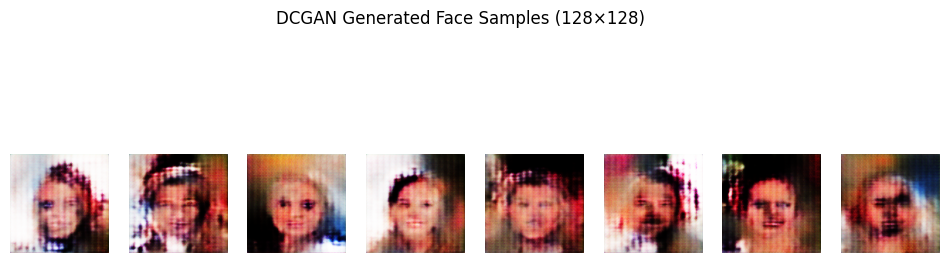

In [ ]:
# =====================================================
# DCGAN (FIXED SHAPES): Generator + Discriminator + Train
# =====================================================

GAN_LATENT_DIM = 100

# -------------------------
# Generator (128x128 output)
# -------------------------
def build_generator():
    z = layers.Input(shape=(GAN_LATENT_DIM,))

    x = layers.Dense(16 * 16 * 256, use_bias=False)(z)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Reshape((16, 16, 256))(x)

    x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", use_bias=False)(x)  # 32x32
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", use_bias=False)(x)   # 64x64
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(32, 4, strides=2, padding="same", use_bias=False)(x)   # 128x128
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    out = layers.Conv2DTranspose(
        3, 3, strides=1, padding="same", activation="sigmoid"
    )(x)

    return keras.Model(z, out, name="Generator")


# -------------------------
# Discriminator (128x128)
# -------------------------
def build_discriminator():
    x = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    h = layers.Conv2D(64, 4, strides=2, padding="same")(x)   # 64x64
    h = layers.LeakyReLU(0.2)(h)

    h = layers.Conv2D(128, 4, strides=2, padding="same")(h)  # 32x32
    h = layers.LeakyReLU(0.2)(h)

    h = layers.Conv2D(256, 4, strides=2, padding="same")(h)  # 16x16
    h = layers.LeakyReLU(0.2)(h)

    h = layers.Flatten()(h)
    out = layers.Dense(1)(h)

    return keras.Model(x, out, name="Discriminator")


# -------------------------
# Instantiate
# -------------------------
generator = build_generator()
discriminator = build_discriminator()

bce = keras.losses.BinaryCrossentropy(from_logits=True)
gen_opt = keras.optimizers.Adam(1e-4, beta_1=0.5)
disc_opt = keras.optimizers.Adam(1e-4, beta_1=0.5)


# -------------------------
# Training Step
# -------------------------
@tf.function
def gan_train_step(real_images):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal((batch_size, GAN_LATENT_DIM))

    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
        fake_images = generator(noise, training=True)

        real_logits = discriminator(real_images, training=True)
        fake_logits = discriminator(fake_images, training=True)

        d_loss = (
            bce(tf.ones_like(real_logits), real_logits) +
            bce(tf.zeros_like(fake_logits), fake_logits)
        )

        g_loss = bce(tf.ones_like(fake_logits), fake_logits)

    d_grads = d_tape.gradient(d_loss, discriminator.trainable_weights)
    g_grads = g_tape.gradient(g_loss, generator.trainable_weights)

    disc_opt.apply_gradients(zip(d_grads, discriminator.trainable_weights))
    gen_opt.apply_gradients(zip(g_grads, generator.trainable_weights))

    return d_loss, g_loss


# -------------------------
# Training Loop
# -------------------------
for epoch in range(EPOCHS):
    for real_batch in celeba_ds.take(200):
        d_loss, g_loss = gan_train_step(real_batch)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"D Loss: {d_loss.numpy():.4f} | "
        f"G Loss: {g_loss.numpy():.4f}"
    )


# -------------------------
# Sampling
# -------------------------
noise = tf.random.normal((8, GAN_LATENT_DIM))
samples = generator(noise, training=False)

plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(samples[i])
    plt.axis("off")

plt.suptitle("DCGAN Generated Face Samples (128×128)")
plt.show()


## 8. Comparative Analysis

The assignment implemented and compared four generative modeling approaches — Variational Autoencoder (VAE), β-VAE, Vector Quantized VAE (VQ-VAE) with PixelCNN prior, and DCGAN — for face reconstruction, attribute manipulation, and realistic face synthesis using the CelebA dataset (128×128 resolution).

All models were trained for 10 epochs using TensorFlow with GPU acceleration. The evaluation focused on reconstruction quality, latent space behavior, interpolation smoothness, attribute controllability, realism of generated faces, training stability, and computational complexity.

### VAE Results

• Successfully reconstructed faces </br>
• Latent interpolation produced smooth morphing between identities</br>
• Training stable and fast</br>
• Outputs slightly blurry due to Gaussian reconstruction loss</br>

### Observation:
VAE learns a smooth and continuous latent space but sacrifices sharpness.</br>

#### β-VAE Results (β = 2, 4, 10)

• Increasing β improved disentanglement</br>
• Individual latent dimensions controlled interpretable features (smile, pose, gender traits)</br>
• Higher β reduced reconstruction fidelity</br>

#### Trade-off observed:
Higher β -> better control but blurrier images </br>

Observation:</br>
Best model for controllable face editing and understanding latent structure.

### VQ-VAE + PixelCNN Results

• Discrete codebook reduced reconstruction blur</br>
• Sharper and more detailed reconstructions than VAE</br>
• PixelCNN prior enables realistic sampling from learned latent maps</br>
• Training slower and computationally heavier</br>

Observation:</br>
Provides a strong balance between reconstruction quality and generative ability.

### GAN (DCGAN) Results

• Generated the most realistic and sharp faces</br>
• High visual fidelity and texture quality</br>
• No encoder -> cannot reconstruct or edit specific faces</br>
• Training less stable and sensitive to hyperparameters</br>

Observation:</br>
Best for pure generation, weakest for latent control.

### Key Insights

• Continuous latent spaces → smooth interpolation (VAE family)</br>
• Disentangled latents → interpretable control (β-VAE)</br>
• Discrete codes → sharper reconstructions (VQ-VAE)</br>
• Adversarial training → highest realism (GAN)</br>
• No single model optimizes reconstruction, control, and realism simultaneously</br>

Hence, generative modeling involves an inherent trade-off between interpretability and visual fidelity.</br>

### Conclusion</br>

From the Assignment, we conclude:

• VAE is a stable and simple baseline</br>
• β-VAE is best for controllable attribute manipulation</br>
• VQ-VAE improves reconstruction sharpness with discrete representations</br>
• GAN produces the most photorealistic faces</br>

Therefore, the choice of model depends on the task:

Editing -> β-VAE

Reconstruction -> VQ-VAE

Realistic synthesis -> GAN
